In [1]:
import numpy as np
import cv2
import skimage
import math
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
from scipy import stats
from statistics import mean 
from collections import OrderedDict
import plotly.graph_objects as go
import pandas as pd

#Optional modules
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform

In [2]:
#import watershed

In [3]:
img = cv2.imread('../example_images/sem_1.jpg',0)

In [4]:
def boundary_detection(img, thres = 20):
        '''
        thres: threshold to distinguish the scale bar background with particle background by grey scale
        for now only work for SEM img, needs update if apply to different imgs
        scan from upper to bottom, also needs update if need scan from left to right
        
        img: input image in gray scale
        thres: threshold for contrast of distinguishing the boundary, i.e larger thres means higher contrast for boundary
        '''
        mode_list = []
        for line in range(len(img)):
            mode = stats.mode(img[line])
            mode_list.append(int(mode[0]))

            if line >= 1:
                mode_mean = mean(mode_list)
                if mode_mean - int(mode[0]) >= thres:
                    boundary = line
                    break

        return boundary

In [5]:
def corner_detection(img, actual_len):
    """
    This function is used to find the length of each pixel in nm.
    The unit of the output length_each_pixel is nm
    
    img: input image in gray scale
    actual_len: real length in micrometer
    """ 
    
    def dilated_image(img,sigma=1):
        """
        filtering regional maxima to find bright features by 
        using gaussian filter and reconstruction
        simga: standard deviation for Gaussian kernel 
        """
        # Convert to float: Important for subtraction later which won't work with uint8
        img = gaussian_filter(img, sigma)
        seed = np.copy(img, sigma)
        seed[1:-1, 1:-1] = img.min()
        mask = img

        dilated = reconstruction(seed, mask, method='dilation')
        return dilated
    
    
    
    
    actual_len = actual_len*1000
    height = img.shape[0]
    width = img.shape[1]
    #find the bottom part of the SEM image. Here we used the return refunction 
    ime = img[boundary_detection(dilated_image(img,1)): , : ]
    
    # find the smallest area of interest
    boundary_v = []
    thres = 100
    for i in range(ime.shape[1]):
        if ime[:,i][0] > thres:
            boundary_v.append(i)
    
    #determine the smaller one of the scale bar region
    ime = img[boundary_detection(dilated_image(img,1)): , boundary_v[-1]+10: ]
    
    boundary_h = []
    for i in range(ime.shape[0]):
        if ime[i,:][0] > thres:
            boundary_h.append(i)
    ime = img[boundary_detection(dilated_image(img,1)):boundary_detection(dilated_image(img,1))+boundary_h[0] , boundary_v[-1]+10: ]
    
    tform = AffineTransform()
    image = warp(ime,tform.inverse)
    coords = corner_peaks(corner_harris(image))
    coords_subpix = corner_subpix(image, coords)
    
    #get the length of the scale bar
    #length_scale_bar = abs(coords[0][1] - coords[1][1])
    
    scales = []
    threshold = 500
    for i in range(len(coords)):
        for j in range(len(coords)):
            if j <= i:
                continue
            else:
                if coords[i][0] == coords[j][0]:
                    scale = abs(coords[i][1] - coords[j][1])
                    if scale > threshold:
                        scales.append((coords[i][0],scale))
                    else:
                        continue
                else:
                    continue
    scalebar = []
    for i in range(len(scales)):
        n_count = 0
        for j in range(len(scales)):
            if scales[i][0] == scales[j][0]:
                n_count += 1
            else:
                continue
        if n_count == 1:
            scalebar.append(scales[i][1])
        else:
            continue
    
    for i in range(len(scalebar)):
        num = scalebar.count(scalebar[i])
        if num >= 2:
            final_scale = scalebar[i]
        else:
            continue
    
    #length of each pixel
    length_each_pixel = actual_len/final_scale
    
    # length of each pixel
    #length_each_pixel = actual_len/length_scale_bar
    
    
    #plot the figure with corner detected
#     fig, ax = plt.subplots(figsize=(15,15))
#     ax.imshow(image, cmap=plt.cm.gray)
#     ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
#             linestyle='None', markersize=6)
#     ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=10)
#     plt.show()
    return length_each_pixel

In [6]:
length_each_pixel = corner_detection(img, 1)

In [7]:
def img_pread(img, thres = 20, cut = True):
    '''
    Pretreatment for the picture to get a dilated and boundary cutted image
    
    img: input image in gray scale
    thres: threshold for contrast distinguishing the boundary
    cut: boolean value to set if the img be cutted
    '''
    #Pretreatment for the boundary detection
    image = img
    image = gaussian_filter(image, 1)
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image
    dilated = reconstruction(seed, mask, method='dilation')
    
    if cut == True:
        image = mask - dilated
        bound = boundary_detection(dilated)
        img_c = image[:bound,:]
        img_c = img_c.astype(np.uint8)
    else:
        img_c = image
    
    return img_c

In [8]:
img_filtered = img_pread(img)

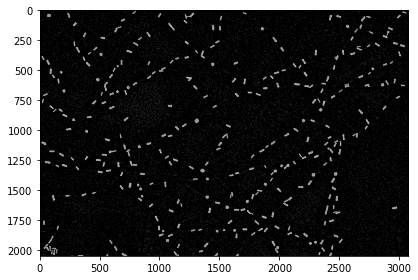

In [9]:
io.imshow(img_filtered)

In [10]:
def peri_avg(contours):
    '''
    Assistant function for determine the average perimeter from all contours
    
    contours: contours from the image
    '''
    peri_c_tot = 0
    for c in contours:
        peri_c_tot += cv2.arcLength(c, True)
    peri_avg = peri_c_tot / len(contours)

    return peri_avg

In [11]:
def contour_capture(img, 
                    noise_factor = 0.25,
                    thresh_method = cv2.THRESH_BINARY,
                    area_thresh = 300):
    '''
    The function captures the contours from the given imgs
    Returns contours
    
    img: input image in gray scale
    noise_factor: factor used to set threshold for the threshold function
    thresh_method: please refer to cv2.threshold
    area_thresh: threshold to ignore noise contours
    '''
    _, threshold = cv2.threshold(img, img.max() * noise_factor, img.max(), thresh_method)
    contours, _=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in contours if cv2.contourArea(contour) >= area_thresh]
    
    return contours

In [12]:
contours = contour_capture(img_filtered)

In [13]:
def shape_radar(contours, img, thresh_di = 1.09, thres_poly = 1.75):
    '''
    Takes input from contour_capture
    return a annotated img from setted threshold
    Model tunning is possible by using different predictions provided below
    
    contours: contours from the image
    img: dilated image from previous function
    '''

    #Create plot, copy the img and convert into color scale
    plt.figure(figsize=(20,16))
    dilated_c = img.copy()
    dilated_c = cv2.cvtColor(dilated_c,cv2.COLOR_GRAY2RGB)
    avg_c = peri_avg(contours)
    
    for c in contours:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        #Optional predictors
        area = cv2.contourArea(c)
        len_c = round(cv2.arcLength(c, True), 1)
        r_area_len = round((area/len_c),1)
        r_peri = len_c / avg_c

        if r_peri <= thresh_di:
            cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
        elif r_peri > thresh_di and r_peri <= thres_poly:
            if area > 900:
                cv2.putText(dilated_c, 'dimer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0), 3)
                cv2.drawContours(dilated_c, [box], 0, (255, 0, 0), 3)
            else:
                cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
        elif r_peri > thres_poly:
            cv2.putText(dilated_c, 'polymer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(0, 255, 0), 3) 
            cv2.drawContours(dilated_c, [box], 0, (0, 255, 0), 3)

    return dilated_c


In [14]:
img_shape = shape_radar(contours, img_filtered)

<Figure size 1440x1152 with 0 Axes>

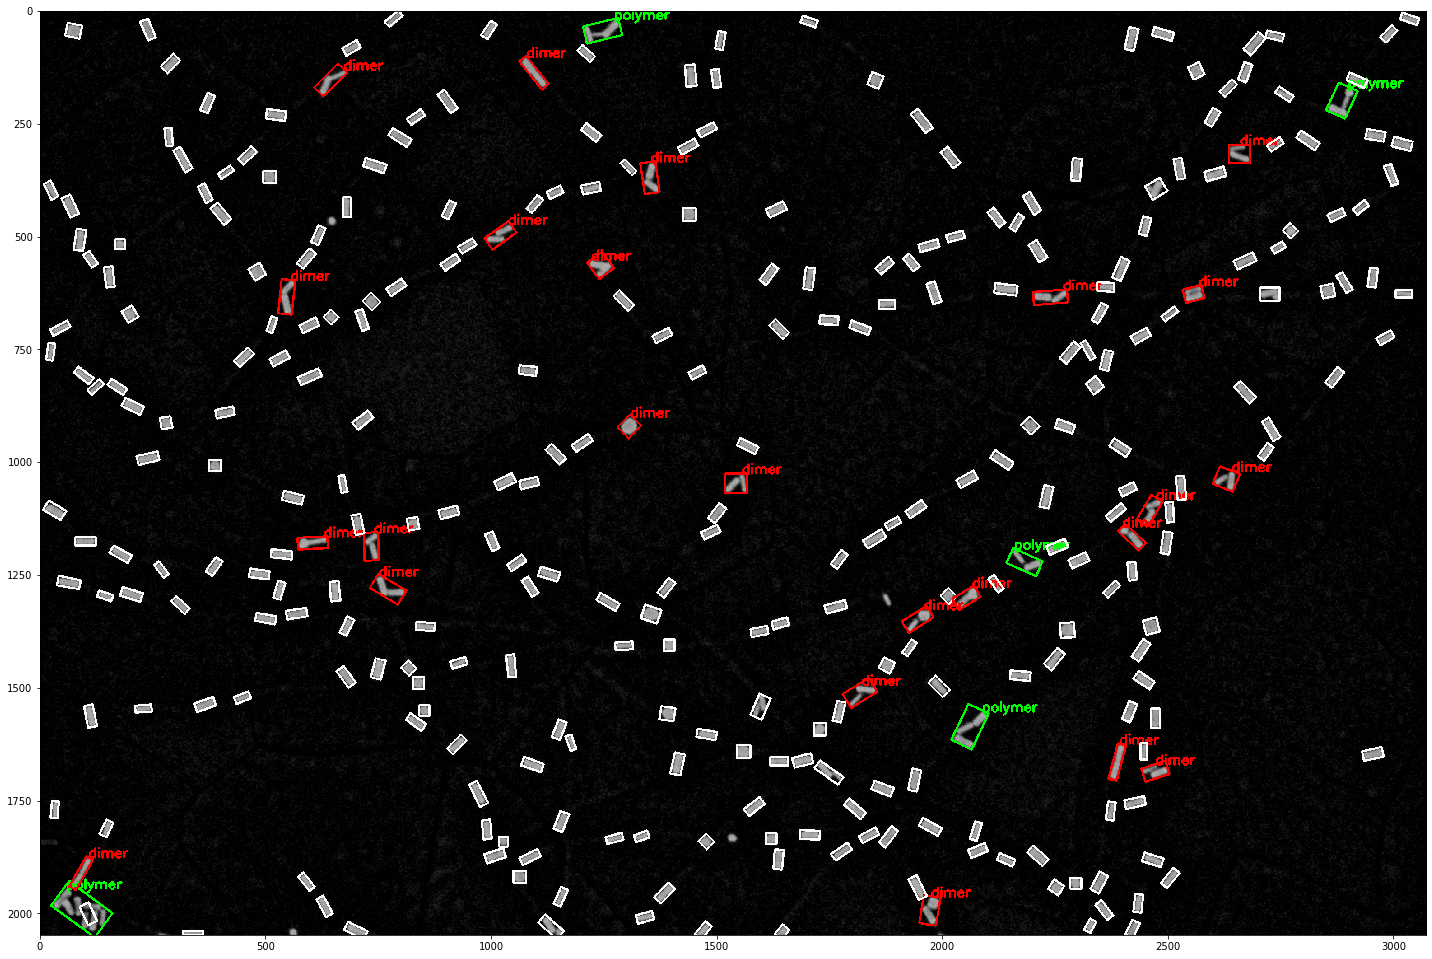

In [15]:
plt.figure(figsize=(20,16))
io.imshow(img_shape)

# Adapted from partycool_my


## Plotly_trail: https://plot.ly/python/histograms/

In [20]:
#For reference
def area_summary(contours,converted = True,convert_factor = 0, enable_poly = True, thres = 1.09, spherical= False):
    '''
    function to calculate particles area
    enable_poly: when it is True,all polymers is considered. When it is False, only monomer is considered
    thres: threshold based on the ratio between contour arclength and average arclength
    output is the list of each particle's area and if it is spherical, output is also a list of the radius of each particles 
    '''
    
    areas=[]
    if enable_poly == True:
        contours = contours
    elif enable_poly == False:
        avg_c = peri_avg(contours)
        contours = [contour for contour in contours if (cv2.arcLength(contour, True) / avg_c) <= thres]
    
    areas = [cv2.contourArea(contour) for contour in contours]
    #output of area will be a 2D array
    #Conversion part
    if converted == True:
        if convert_factor == 0:
            print('Please decide convert factor!')
            
        else:
            areas = [int(a * (convert_factor ** 2)) for a in areas]
    elif converted == False:
        areas = [int(a) for a in areas]
    #converting area to radius
    if spherical == True: 
        r = [int(math.sqrt(a/math.pi)) for a in areas]
    elif spherical == False:
        r = [0 for a in areas]
    #Conversion part
    return areas,r

In [23]:
def partycool_summary(contours, convert_factor = 0, enable_poly = True, thresh_di = 1.09, thres_poly = 1.75, spherical= False ):
    '''
    returns a dataframe that summarized the particle information
    '''
    
    if enable_poly == True:
        contours = contours
    elif enable_poly == False:
        avg_c = peri_avg(contours)
        contours = [contour for contour in contours if (cv2.arcLength(contour, True) / avg_c) <= thresh_di]
    
    area, r = area_summary(contours,converted = True,convert_factor = 1.2, enable_poly = True,thres = 1.09, spherical= False)
    
    loc_x = []
    loc_y = []
    aspect_r = []
    area_l = []
    arealen_r = []
    category_l = []
    cX_au=[]
    cY_au=[]
    
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        aspect_ratio = float(w)/h
        area = cv2.contourArea(c)
        avg_c = peri_avg(contours)
        len_c = round(cv2.arcLength(c, True), 1)
        r_peri = len_c / avg_c
        # center of mass of each particle
        M = cv2.moments(c)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY= int(M["m01"] / M["m00"])
        else:
          # set values as what you need in the situation
            cX, cY = 1,1  
        
        
        category = ''

        if r_peri <= thresh_di:
            category = 'monomer'
        elif r_peri > thresh_di and r_peri <= thres_poly:
            if area > 900:
                category = 'dimer'
            else:
                category = 'monomer'
        elif r_peri > thres_poly:
            category = 'polymer'

        loc_x.append(x)
        loc_y.append(y)
        aspect_r.append(float('%.2g' % aspect_ratio))
        area_l.append(int(area))
        category_l.append(category)
        cX_au.append(cX)
        cY_au.append(cY)
    #Conversion part
    if convert_factor != 0:
        area_list = [a * (convert_factor ** 2) for a in area_l]
    elif convert_factor == 0:
        area_list = area_l

    if spherical==True:
        result_dict = {'Cx' : cX_au, 
                       'Cy' : cY_au,
                       'Area (nm\u00b2)' : areas,
                       'Radius (nm)' : r,
                       'Category' : category_l}
    elif spherical==False:
          result_dict = {'Cx' : cX_au, 
                         'Cy' : cY_au,
                         'Aspect Ratio' : aspect_r,
                         'Area (nm\u00b2)' : area_list,
                         'Radius (nm)' : r,
                         'Category' : category_l}
                     #change the 'Area (nm\u00b2)' to area_list        
                
    result_df = pd.DataFrame.from_dict(result_dict)
    
    return result_df


In [24]:
df = partycool_summary(contours, convert_factor = 1.2, enable_poly = True, thresh_di = 1.09, thres_poly = 1.75, spherical= False)

In [25]:
df

Cx    Cy  Aspect Ratio  Area (nm²)  Radius (nm) Category
0     337  2043          4.60      488.16            0  monomer
1    1644  2038          1.40      524.16            0  monomer
2    1469  2036          1.20      652.32            0  monomer
3     698  2036          1.60     1019.52            0  monomer
4    2420  2033          1.00      761.76            0  monomer
5    2326  2026          0.81      512.64            0  monomer
6    1132  2029          1.10     1206.72            0  monomer
7    1339  2008          1.90      773.28            0  monomer
8    2357  1993          0.92      846.72            0  monomer
9     630  1984          0.74      927.36            0  monomer
10   1973  1991          0.62     1941.12            0    dimer
11   2432  1977          0.50      784.80            0  monomer
12   1153  1963          0.66      748.80            0  monomer
13     92  1993          1.30     6431.04            0  polymer
14    104  2000          0.56      515.52            0  monomer
15   1383  1954          0.98     1149.12            0  monomer
16   2250  1942          0.97      766.08            0  monomer
17   2293  1932          1.00      669.60            0  monomer
18   1943  1942          0.71     1213.92            0  monomer
19    589  1930          0.81      709.92            0  monomer
20   2346  1931          0.72     1090.08            0  monomer
21   1062  1918          1.00      871.20            0  monomer
22   2503  1921          0.85      933.12            0  monomer
23     91  1910          0.67     1431.36            0    dimer
24   2140  1881          1.30      668.16            0  monomer
25   2464  1881          1.50      967.68            0  monomer
26   1085  1875          1.50      979.20            0  monomer
27   1635  1880          0.47     1018.08            0  monomer
28   1007  1872          1.50     1055.52            0  monomer
29   2209  1872          1.00     1167.84            0  monomer
..    ...   ...           ...         ...          ...      ...
286  2596   237          0.78      832.32            0  monomer
287   371   205          0.60      861.12            0  monomer
288   902   202          0.87     1133.28            0  monomer
289  2756   187          1.40      630.72            0  monomer
290  2883   208          0.86     1958.40            0  polymer
291  2630   172          0.97      718.56            0  monomer
292  2917   155          1.40      973.44            0  monomer
293  1850   155          0.93      861.12            0  monomer
294  1497   151          0.50      819.36            0  monomer
295   643   157          1.10     1611.36            0    dimer
296  1441   145          0.52     1196.64            0  monomer
297  2560   135          0.91      924.48            0  monomer
298  2669   138          0.63      884.16            0  monomer
299  1093   137          0.84     1818.72            0    dimer
300   289   118          0.97      977.76            0  monomer
301  1209    96          1.00      724.32            0  monomer
302   690    83          1.40      794.88            0  monomer
303  2690    73          0.85     1267.20            0  monomer
304  2735    57          1.90      668.16            0  monomer
305  1506    66          0.47      696.96            0  monomer
306  2487    53          1.60     1013.76            0  monomer
307  2417    62          0.57     1172.16            0  monomer
308  2987    53          1.00      792.00            0  monomer
309    74    45          1.10     1123.20            0  monomer
310   995    43          0.76      776.16            0  monomer
311   238    43          0.60      990.72            0  monomer
312  1243    47          1.50     2223.36            0  polymer
313  1703    26          1.70      550.08            0  monomer
314  3034    20          1.80      695.52            0  monomer
315   783    19          1.00      688.32            0  monomer

[316 rows x 6 columns]

In [31]:
def partycool_plots(dataframe, aspect, interactive = False):
    '''
    dataframe: df from partycool_summary
    aspect: what user want to see
    interactive: define whether the plots be interactive
    '''
    if aspect == 'area':
        area = dataframe['Area (nm\u00b2)']
        if interactive == False:
            plt.figure(figsize=(8, 6))
            _ = plt.hist(areas, bins=40, color='gray')
            plt.xlabel('Area of Nanoparticles (pixel\u00b2)', fontsize=16)
            plt.ylabel('Count', fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            print("Total # of Au Particles :\n", len(areas))
        elif interactive == True:
            fig = go.Figure()
            fig.add_trace(go.Histogram(
                x=area,
                name='Height',
                xbins=dict(
                    start=0,
                    end=60,
                    size=5
                ),
                marker_color='#800080',
                opacity=0.75
            ))
            fig.show()
    elif aspect == 'aspect_ratio':
        aspectratio = dataframe['Aspect Ratio']
        if interactive == False:
            plt.figure(figsize=(8, 6))
            _ = plt.hist(aspectratio, bins=40, color='gray')
            plt.xlabel('Aspect Ratio of Nanoparticles', fontsize=16)
            plt.ylabel('Count', fontsize=16)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            print("Total # of Au Particles :\n", len(aspectratio))
        elif interactive == True:
            fig = go.Figure()
            fig.add_trace(go.Histogram(
                x=aspectratio,
                name='Height',
                xbins=dict(
                    start=0,
                    end=2.5,
                    size=0.1
                ),
                marker_color='#800080',
                opacity=0.75
            )) 
            # can add histnorm='percent' into go.Histogram and the y axis would be percentage

            fig.update_layout(
                title_text='Aspect Ratio', # title of plot
                xaxis_title_text='Aspect ratio', # xaxis label
                yaxis_title_text='Counts', # yaxis label
                bargap=0.15, # gap between bars of adjacent location coordinates
            )
            fig.show() 
    return

In [32]:
partycool_plots(df, 'aspect_ratio', interactive = True)

# Plotly interactive plots

In [71]:
#Example of plotly

areas = [cv2.contourArea(contour) for contour in contours]
fig = go.Figure(data=[go.Histogram(x=areas)])
fig.show()

In [72]:
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=['Oxygen','Hydrogen','Carbon_Dioxide','Nitrogen'],
                             values=[4500,2500,1053,500])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()